In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.executing_eagerly()

True

In [4]:
tf.random.set_seed(777)

# 강의에 설명할 Data입니다
- x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
- Logistic Classification 통해 보라색과 노란색 y_data(Label)을 구분해 보겠습니다.
- Test 데이터는 붉은색의 위치와 같이 추론시 1의 값을 가지게 됩니다.


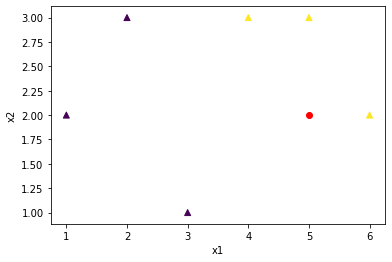

In [5]:
x_train = [[1., 2.],
          [2., 3.],
          [3., 1.],
          [4., 3.],
          [5., 3.],
          [6., 2.]]
y_train = [[0.],
          [0.],
          [0.],
          [1.],
          [1.],
          [1.]]

x_test = [[5.,2.]]
y_test = [[1.]]


x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

colors = [int(y[0] % 3) for y in y_train]
plt.scatter(x1,x2, c=colors , marker='^')
plt.scatter(x_test[0][0],x_test[0][1], c="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Tensorflow Eager
- 위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
- Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
- features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(
x_train))

데이터셋 API는 최종적으로 tf.data.Dataset 추상 클래스에서 상속된 여러가지 클래스 객체를 만든다.

데이터셋 API를 사용하려면 세 가지 단계를 거친다.

- 데이터셋 생성: from_tensor_slices(), from_generator() 클래스 메서드 또는 tf.data.TFRecordDataset 클래스를 사용하여 메모리나 파일에 있는 데이터를 데이터 소스로 만든다.
- 데이터셋 변형: map(), filter(), batch() 등의 메서드를 사용하여 데이터 소스를 변형한다.
- for 반복문에서 데이터셋 사용

from_tensor_slices 클래스 메서드를 사용하면 리스트, 넘파이, 텐서플로 자료형에서 데이터셋을 만들 수 있다.

batch() 메서드는 지정한 개수의 데이터를 묶어서 출력한다.


위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
- W와 b은 학습을 통해 생성되는 모델에 쓰이는 Weight와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

In [7]:
W = tf.Variable(tf.zeros((2,1)), name = 'weight')
b = tf.Variable(tf.zeros((1,)), name = 'bias')

Sigmoid 함수를 가설로 선언합니다
Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다
$$ \begin{align} sigmoid(x) & = \frac{1}{1+e^{-x}} \\\\\ \end{align} $$
sigmoid

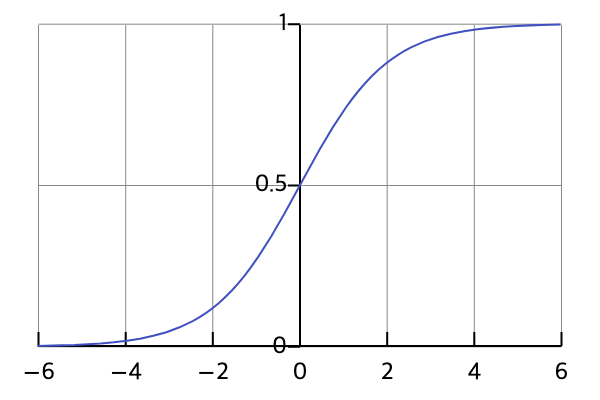

In [8]:
def logistic_regression(features):
    hypothesis = tf.divide(1., 1. + tf.exp(tf.matmul(features, W) + b))
    return hypothesis

가설을 검증할 Cost 함수를 정의합니다
$$ \begin{align} cost(h(x),y) & = −log(h(x)) & if & y=1 \\\\\ cost(h(x),y) & = -log(1−h(x)) & if & y=0 \end{align} $$
위 두수식을 합치면 아래과 같습니다

In [14]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(
    labels * tf.math.log(logistic_regression(features)) + 
    (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
# optimizer는 cost가 최소화 될 수 있도록 변수들을 조정하는 것이다.

추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴합니다.
- Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.
- 가설을 통해 실재 값과 비교한 정확도를 측정합니다

In [15]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype = tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels),
                                     dtype = tf.int32))
    return accuracy

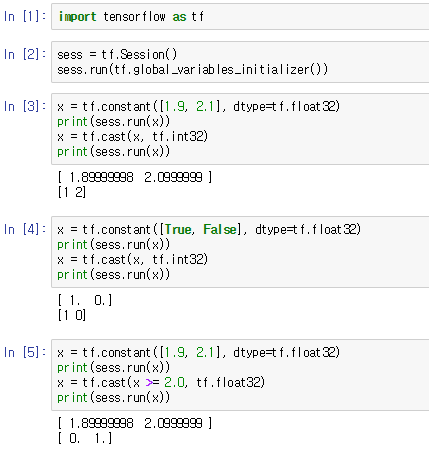
- tf.cast는 부동소수점형에서 정수형으로 바꾼 경우 소수점을 버린다
- boolean 형태인 경우 True이면 1, Fasle면 0을 출력한다.

GradientTape를 통해 경사값을 계산한다

In [16]:
def grad(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features), features, labels)
    return tape.gradient(loss_value, [W, b])

학습을 실행한다
- 위의 데이터를 Cost함수를 통해 학습시킨 후 모델을 생성한다.
- 새로운 데이터를 통한 검증 수행 [5,2]의 데이터로 테스트 수행(그래프상 1이 나와야 정상)

In [19]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels in iter(dataset):
        grads = grad(features, labels)
        # 밑의 코드는 gradient descent를 통해 cost를 minimize하는 과정
        optimizer.apply_gradients(grads_and_vars=zip(grads, [W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, 
            loss_fn(logistic_regression(features), features, labels)))
test_acc = accuracy_fn(logistic_regression(x_test), y_test)
print('Testset Accuracy: {:.4f}'.format(test_acc))

Iter: 0, Loss: 0.4143
Iter: 100, Loss: 0.4065
Iter: 200, Loss: 0.3991
Iter: 300, Loss: 0.3921
Iter: 400, Loss: 0.3854
Iter: 500, Loss: 0.3789
Iter: 600, Loss: 0.3727
Iter: 700, Loss: 0.3666
Iter: 800, Loss: 0.3607
Iter: 900, Loss: 0.3550
Iter: 1000, Loss: 0.3495
Testset Accuracy: 1.0000
